#  Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## [7.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline

import time
time_start = time.time()

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import warnings
warnings.filterwarnings("ignore")

# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 



#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print ('Importing all necceassy modules done! Time elapsed: {} seconds'.format(time.time()-time_start))

C:\Users\avinash\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Importing all necceassy modules done! Time elapsed: 31.948670864105225 seconds


In [2]:
print(filtered_data.shape) #looking at the number of attributes and size of the data
filtered_data.head()

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


#  Exploratory Data Analysis

## [7.1.2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [3]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [6]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [8]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [9]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

## 7.2.3  Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [10]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [11]:
#nltk.download('stopwords')- To download or upgrade Stopwords to latest version
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print("*"*50)
print(sno.stem('tasty'))
print("*"*50)
# excluding words 'not',isn't and wasn't from set of stopwords.
stop.remove("not") 
stop.remove("isn't")
stop.remove("wasn't")
print(stop)

{'above', 'such', 'don', 'your', "shan't", 'mightn', 'itself', 'from', 'shouldn', "you'll", 'nor', 'am', 'were', 'who', 'any', 'hasn', 'out', "won't", 'so', 'doesn', 'these', 'my', 'about', 'will', 'of', 'her', "you've", 'but', 'with', 'here', 'weren', 'couldn', 'on', 'd', 'same', "it's", 'his', 'each', 'he', 'most', "doesn't", 'do', 'have', 'down', 'again', 'after', 'when', 'very', 'and', 'herself', 'm', "needn't", 'wouldn', 'their', "isn't", 'whom', 'in', 'against', 'through', 'ours', 'during', 'below', 'wasn', 'as', 'them', 'hers', 'by', 'yourself', 'y', 'its', 'off', "should've", 'because', 'yours', 'himself', 'both', 'other', 'i', 'didn', 'you', 'our', "wasn't", 'ain', 'being', 'should', "hasn't", 'does', "haven't", 'further', "mustn't", 'him', 'be', 'where', 'not', 've', 't', "don't", 'hadn', 'won', "you'd", 'those', 'an', 'is', 'mustn', 's', 'for', 'to', 'until', 'up', 'it', 'into', 'under', 're', 'over', 'this', 'then', 'themselves', 'shan', 'why', 'some', 'has', 'too', 'than',

In [12]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.

time_start = time.time()

i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1
print ('Important Preprocessing step done! Time elapsed: {} seconds'.format(time.time()-time_start))

Important Preprocessing step done! Time elapsed: 368.54730200767517 seconds


In [13]:
#print(all_positive_words)
print(all_positive_words[0:4])
#print(all_negative_words)
print(all_negative_words[0:4])
print(np.shape(all_positive_words))
print(np.shape(all_negative_words))
print(np.shape(final_string))
print(final_string[0:4])

[b'witti', b'littl', b'book', b'make']
[b'one', b'best', b'children', b'book']
(11757300,)
(2408867,)
(364171,)
[b'witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg', b'grew read sendak book watch realli rosi movi incorpor love son love howev miss hard cover version paperback seem kind flimsi take two hand keep page open', b'fun way children learn month year learn poem throughout school year like handmot invent poem', b'great littl book read nice rhythm well good repetit littl one like line chicken soup rice child get month year wonder place like bombay nile eat well know get eat kid mauric sendak version ice skate treat rose head long time wont even know came surpris came littl witti book']


In [14]:
#Taking random samples of size (10000,) from list of all_positive_words and all_negative_words.
positive_words_10k = np.random.choice(all_positive_words, 10000)
negative_words_10k = np.random.choice(all_negative_words, 10000)
print(positive_words_10k[0:10])
print(negative_words_10k[0:10])

[b'guess' b'orbit' b'treat' b'burger' b'find' b'fresh' b'least' b'shell'
 b'greasi' b'item']
[b'particular' b'flavor' b'flavor' b'broken' b'protein' b'whether' b'kind'
 b'eat' b'theyr' b'care']


In [15]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [16]:
final_v1 = final

In [17]:
final.head(3) #below the processed review can be seen in the CleanedText Column 

time_start = time.time()

# store final table into an SQlLite table ('final_v1.sqlite') for future reference.
conn = sqlite3.connect('final_v1.sqlite')
c=conn.cursor()
conn.text_factory = str
final_v1.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)
print ('Storing final_v1 table into an SQlLite table done! Time elapsed: {} seconds'.format(time.time()-time_start))

Storing final_v1 table into an SQlLite table done! Time elapsed: 39.45611119270325 seconds


In [18]:
#Taking 10k random positive reviews from cleaned SQLlite table final. 
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score = 'positive'
ORDER BY RANDOM()
LIMIT 10000 OFFSET 0;
""", conn)

positive_reviews = display
positive_reviews.head(3)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,433443,468729,B003QWGG0M,AMG30D2CYVLYS,LTNJ,1,1,positive,1306972800,Awesome afternoon snack!,Perfect size and at 90 calories it's a hit wit...,perfect size calori hit oclock pick also pair ...
1,131419,142693,B001FA1KJO,AYIBT61B66F46,Boogie,0,0,positive,1332028800,Folgers Coffee bags,I am the only one here who drinks coffee in th...,one drink coffe morn wast make pot one person ...
2,243862,264440,B002UQE206,A1XMLDELA2WROU,"Jennifer H. Schlebach ""SHEROX""",1,1,positive,1277683200,Good Smooth Cup,Don't be scared off by this being labeled as e...,dont scare label extra bold realli not brew si...


In [19]:
#Taking 10k random negative reviews from cleaned SQLlite table final. 
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score = 'negative'
ORDER BY RANDOM()
LIMIT 10000 OFFSET 0;
""", conn)

negative_reviews = display
negative_reviews.head(3)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,377528,408240,B003QR13SC,A17GK9E70O7Y9R,Grandma in Oregon,5,5,negative,1301788800,Not the same creamy chowder....this is soup.,Really disappointed in the change. Not at all...,realli disappoint chang not expect wish hadnt ...
1,145567,157920,B003NRTGV6,A12D1KTEGHPDO2,"Leckie ""Loyal Amazon Shopper""",0,2,negative,1329350400,Made in China,Be aware that these treats are made in China. ...,awar treat made china receiv christma gift dog...
2,394943,427071,B000E63LLU,A2JQJYR7SX2C94,"J. Stone ""Teddy's Mom""",3,26,negative,1148083200,is it really healthy?,I read in a review that if you are on a blood ...,read review blood thinner tea not good make un...


In [20]:
#Combining postive reviews and negative reviews
final20k = []
final20k = pd.concat([positive_reviews,negative_reviews], ignore_index=True)
final20k.head(3)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,433443,468729,B003QWGG0M,AMG30D2CYVLYS,LTNJ,1,1,positive,1306972800,Awesome afternoon snack!,Perfect size and at 90 calories it's a hit wit...,perfect size calori hit oclock pick also pair ...
1,131419,142693,B001FA1KJO,AYIBT61B66F46,Boogie,0,0,positive,1332028800,Folgers Coffee bags,I am the only one here who drinks coffee in th...,one drink coffe morn wast make pot one person ...
2,243862,264440,B002UQE206,A1XMLDELA2WROU,"Jennifer H. Schlebach ""SHEROX""",1,1,positive,1277683200,Good Smooth Cup,Don't be scared off by this being labeled as e...,dont scare label extra bold realli not brew si...


# [7.2.2] Bag of Words (BoW)

In [21]:
#BoW
count_vect = CountVectorizer() #Taking only unigrams
final_counts = count_vect.fit_transform(final20k['CleanedText'].values)
print("the type of count vectorizer ",type(final_counts))
print("the shape of our text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])
#standardized_data = Toarray.(final_counts)
final_counts[0,2]

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of our text BOW vectorizer  (20000, 18400)
the number of unique words  18400


0

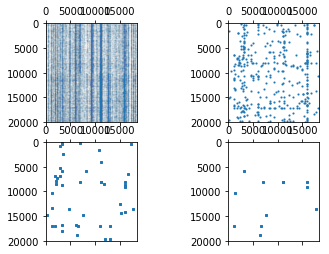

In [22]:
#visualizing sparse matrix with different precisions(i.e the final_counts values should be > precision) and varying markersize
import matplotlib
matplotlib.axes.Axes.spy
matplotlib.pyplot.spy

fig, axs = plt.subplots(2, 2)
ax1 = axs[0, 0]
ax2 = axs[0, 1]
ax3 = axs[1, 0]
ax4 = axs[1, 1]

ax1.spy(final_counts, precision=1, markersize=0.01)
ax2.spy(final_counts, precision=10, markersize=1)
ax3.spy(final_counts, precision=20, markersize=2)
ax4.spy(final_counts, precision=30, markersize=2)

plt.show()
#plt.title("Sparse Matrix");

In [23]:
#Converting sparse matrix into dense matrix or compressed matrix using TruncatedSVD technique.
time_start = time.time()

from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100)
compressed_final_counts = svd.fit_transform(final_counts)

print ('TruncatedSVD BOW(unigrams)done! Time elapsed: {} seconds'.format(time.time()-time_start))

TruncatedSVD BOW(unigrams)done! Time elapsed: 6.174938201904297 seconds


In [24]:
#final_bigram_counts is now compressed.
print("the shape of out of TruncatedSVD tranformation ",compressed_final_counts.shape)

the shape of out of TruncatedSVD tranformation  (20000, 100)


In [25]:
# Data-preprocessing: Standardizing the data
time_start = time.time()

from sklearn.preprocessing import StandardScaler
standardized_final_counts = StandardScaler().fit_transform(compressed_final_counts)
print(standardized_final_counts.shape)
standardized_final_counts[0,:40]

print ('Standardization BOW(unigrams)done! Time elapsed: {} seconds'.format(time.time()-time_start))

(20000, 100)
Standardization BOW(unigrams)done! Time elapsed: 0.2333695888519287 seconds


In [26]:
#Dimensionality reduction of BOW(unigrams) vectors using TSNE.
time_start = time.time()

from MulticoreTSNE import MulticoreTSNE as TSNE
labels_20k = final20k['Score'].values

model = TSNE(n_components=2, random_state=0, perplexity=30,  n_iter=3000, n_jobs = 4)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data_unigram = model.fit_transform(standardized_final_counts)

print ('MulticoreTSNE on BOW(unigrams)done! Time elapsed: {} seconds'.format(time.time()-time_start))
tsne_data_unigram1 = np.vstack((tsne_data_unigram.T, labels_20k)).T #Run this line only once.

MulticoreTSNE on BOW(unigrams)done! Time elapsed: 148.40089869499207 seconds


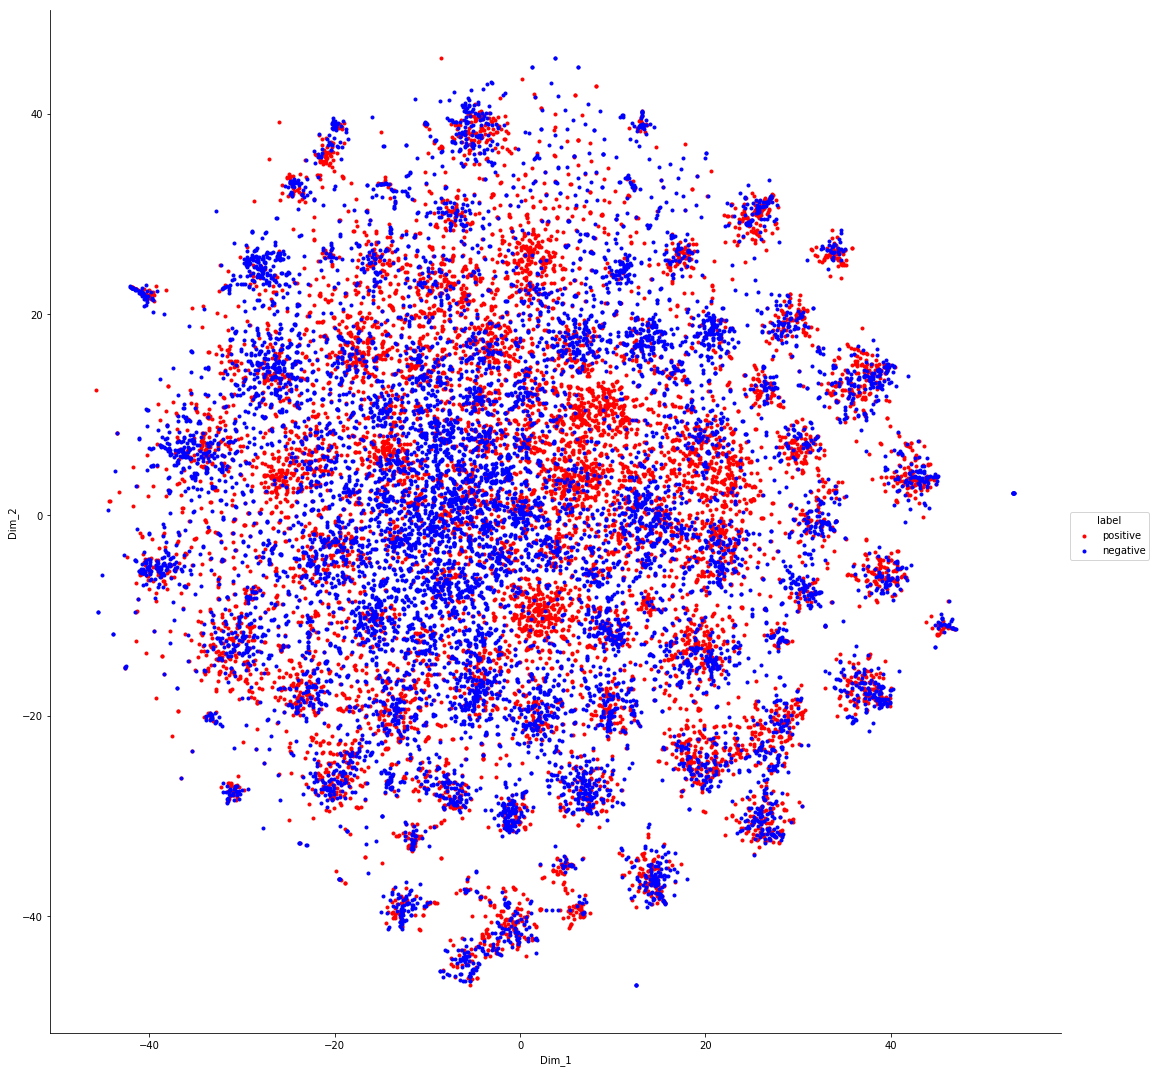

In [63]:
#Plotting TSNE using seaborn
tsne_df_unigram1 = pd.DataFrame(data=tsne_data_unigram1, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df_unigram1, hue="label",hue_kws=dict(marker=[".", "."]),\
              size=15, palette=dict(positive="red", negative="blue"))\
              .map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

<b>Observation:-</b> Both the positive and negative reviews almost overlap for TSNE of BOW(unigrams) which is undesirable.

# [7.2.4] Bi-Grams and n-Grams.

**Motivation**

Now that we have our list of words describing positive and negative reviews lets analyse them.<br>

We begin analysis by getting the frequency distribution of the words as shown below

In [28]:
freq_dist_positive=nltk.FreqDist(all_positive_words)
freq_dist_negative=nltk.FreqDist(all_negative_words)
print("Most Common Positive Words : ",freq_dist_positive.most_common(20))
print("Most Common Negative Words : ",freq_dist_negative.most_common(20))

Most Common Positive Words :  [(b'not', 146797), (b'like', 139429), (b'tast', 129047), (b'good', 112766), (b'flavor', 109624), (b'love', 107357), (b'use', 103888), (b'great', 103870), (b'one', 96726), (b'product', 91033), (b'tri', 86791), (b'tea', 83888), (b'coffe', 78814), (b'make', 75107), (b'get', 72125), (b'food', 64802), (b'would', 55568), (b'time', 55264), (b'buy', 54198), (b'realli', 52715)]
Most Common Negative Words :  [(b'not', 54378), (b'tast', 34585), (b'like', 32330), (b'product', 28218), (b'one', 20569), (b'flavor', 19575), (b'would', 17972), (b'tri', 17753), (b'use', 15302), (b'good', 15041), (b'coffe', 14716), (b'get', 13786), (b'buy', 13752), (b'order', 12871), (b'food', 12754), (b'dont', 11877), (b'tea', 11665), (b'even', 11085), (b'box', 10844), (b'amazon', 10073)]


<b>Observation:-</b> From the above it can be seen that the most common positive and the negative words overlap for eg. 'like' could be used as 'not like' etc. <br>
So, it is a good idea to consider pairs of consequent words (bi-grams) or q sequnce of n consecutive words (n-grams)

In [29]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
count_vect = CountVectorizer(ngram_range=(1,2) ) #in scikit-learn
final_bigram_counts = count_vect.fit_transform(final20k['CleanedText'].values)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (20000, 416538)
the number of unique words including both unigrams and bigrams  416538


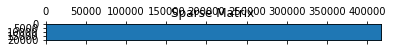

In [30]:
#visualizing the sparse matrix
plt.spy(final_bigram_counts)
plt.title("Sparse Matrix");

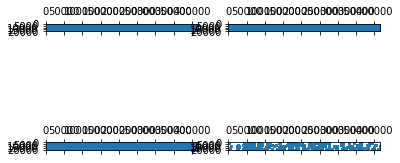

In [31]:
#visualizing sparse matrix with different precisions(i.e the final_counts values should be > precision) and varying markersize
import matplotlib
matplotlib.axes.Axes.spy
matplotlib.pyplot.spy

fig, axs = plt.subplots(2, 2)
ax1 = axs[0, 0]
ax2 = axs[0, 1]
ax3 = axs[1, 0]
ax4 = axs[1, 1]

ax1.spy(final_bigram_counts, precision=0.1, markersize=0.01)
ax2.spy(final_bigram_counts, precision=1, markersize=1)
ax3.spy(final_bigram_counts, precision=2, markersize=2)
ax4.spy(final_bigram_counts, precision=10, markersize=2)

plt.show()
#plt.title("Sparse Matrix");

In [32]:
#Converting sparse matrix into dense matrix or compressed matrix using TruncatedSVD technique.
time_start = time.time()

from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100)
compressed_bigrams_counts = svd.fit_transform(final_bigram_counts)

#final_bigram_counts is now compressed.
print("the shape of out of TruncatedSVD tranformation ",compressed_bigrams_counts.shape)

print ('TruncatedSVD on BOW(bigrams) done! Time elapsed: {} seconds'.format(time.time()-time_start))

the shape of out of TruncatedSVD tranformation  (20000, 100)
TruncatedSVD on BOW(bigrams) done! Time elapsed: 19.89730477333069 seconds


In [33]:
#Dimensionality reduction of BOW(bigrams) vectors using TSNE.
time_start = time.time()

from MulticoreTSNE import MulticoreTSNE as TSNE
labels_20k = final20k['Score'].values

model = TSNE(n_components=2, random_state=0, perplexity=30,  n_iter=3000, n_jobs=6)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data_bigram = model.fit_transform(compressed_bigrams_counts)

print ('MulticoreTSNE BOW(bigrams) done! Time elapsed: {} seconds'.format(time.time()-time_start))
# creating a new data frame which help us in ploting the result data
tsne_data_bigram1 = np.vstack((tsne_data_bigram.T, labels_20k)).T #Run this line only once.

MulticoreTSNE BOW(bigrams) done! Time elapsed: 158.53915309906006 seconds


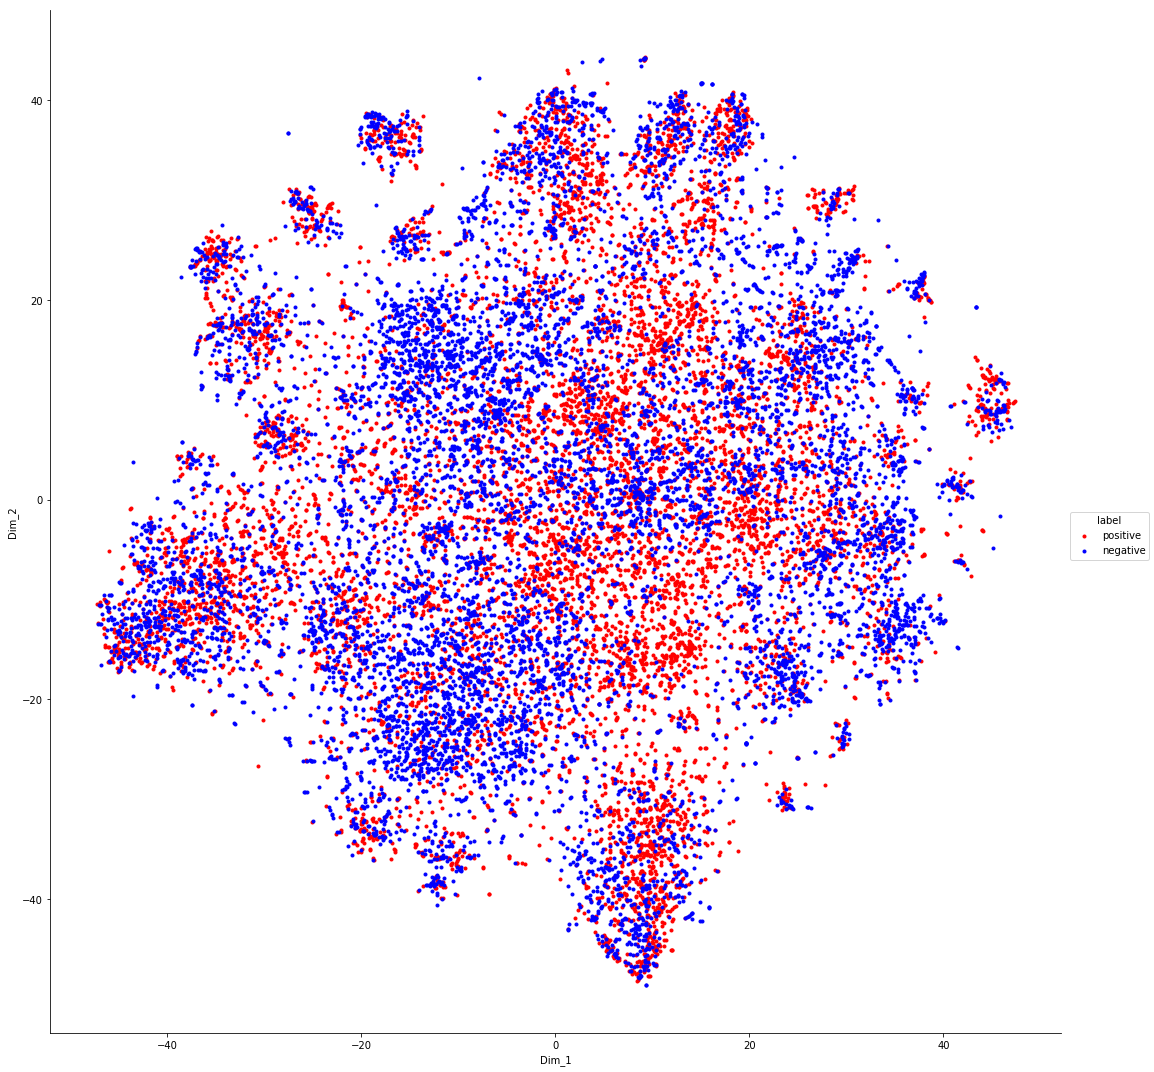

In [64]:
tsne_df_bigram = pd.DataFrame(data=tsne_data_bigram1, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df_bigram, hue="label",hue_kws=dict(marker=[".", "."]),\
              size=15, palette=dict(positive="red", negative="blue"))\
              .map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

<b>Observation:-</b> Both the positive and negative reviews almost overlap for TSNE of BOW(bigrams) more or less the same as we saw for TSNE of BOW(unigrams) which is undesirable.

# [7.2.5] TF-IDF

In [35]:
time_start = time.time()

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2)) #Defining the TF-IDF vectorizer to have unigrams and bigrams.
final_tf_idf = tf_idf_vect.fit_transform(final20k['CleanedText'].values) #Taking CleanedText and tranforming it to final TF-IDF sparse matrix.
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

print ('TfidfVectorizer done! Time elapsed: {} seconds'.format(time.time()-time_start))

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (20000, 416538)
the number of unique words including both unigrams and bigrams  416538
TfidfVectorizer done! Time elapsed: 3.5037457942962646 seconds


In [36]:
features = tf_idf_vect.get_feature_names()
print("some sample features(unique words in the corpus)",features[100:200])
len(features)

some sample features(unique words in the corpus) ['abl', 'abl actual', 'abl add', 'abl afford', 'abl amazon', 'abl avoid', 'abl back', 'abl begin', 'abl bite', 'abl break', 'abl brew', 'abl bring', 'abl buy', 'abl caffein', 'abl calcul', 'abl carri', 'abl caus', 'abl chai', 'abl chew', 'abl choos', 'abl chose', 'abl click', 'abl clip', 'abl communic', 'abl compar', 'abl consum', 'abl contact', 'abl continu', 'abl cook', 'abl cover', 'abl crush', 'abl cut', 'abl daughter', 'abl deal', 'abl decid', 'abl deliv', 'abl detect', 'abl determin', 'abl dig', 'abl digest', 'abl direct', 'abl discov', 'abl distinguish', 'abl dodg', 'abl dog', 'abl domest', 'abl draw', 'abl drink', 'abl eat', 'abl empti', 'abl enjoy', 'abl equal', 'abl erad', 'abl exchang', 'abl expect', 'abl explain', 'abl export', 'abl fall', 'abl feed', 'abl feel', 'abl figur', 'abl final', 'abl find', 'abl fine', 'abl finish', 'abl fit', 'abl fix', 'abl flush', 'abl fresh', 'abl fulfil', 'abl fulli', 'abl get', 'abl give', 'ab

416538

In [37]:
# source: https://buhrmann.github.io/tfidf-analysis.html
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

In [38]:
top_tfidf = top_tfidf_feats(final_tf_idf[90,:].toarray()[0],features,25)

top_tfidf

,feature,tfidf
0,christma,0.245888
1,christma silli,0.227639
2,love childhood,0.227639
3,wasnt gift,0.227639
4,smile christma,0.227639
5,made smile,0.227639
6,purchas mom,0.227639
7,silli wasnt,0.227639
8,get car,0.218599
9,childhood love,0.218599


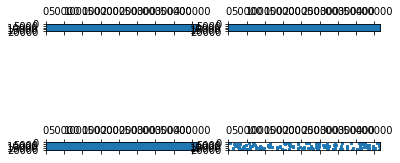

In [39]:
#visualizing sparse matrix with different precisions(i.e the final_tf_idf values should be > precision) and varying markersize
import matplotlib
matplotlib.axes.Axes.spy
matplotlib.pyplot.spy

fig, axs = plt.subplots(2, 2)
ax1 = axs[0, 0]
ax2 = axs[0, 1]
ax3 = axs[1, 0]
ax4 = axs[1, 1]

ax1.spy(final_tf_idf, precision=0, markersize=0.01)
ax2.spy(final_tf_idf, precision=0.1, markersize=1)
ax3.spy(final_tf_idf, precision=0.2, markersize=2)
ax4.spy(final_tf_idf, precision=0.5, markersize=2)

plt.show()
#plt.title("Sparse Matrix");

In [40]:
#Converting sparse matrix into dense matrix or compressed matrix using TruncatedSVD technique.
time_start = time.time()

from sklearn.decomposition import TruncatedSVD
compressed_final_tf_idf = TruncatedSVD(n_components=100).fit_transform(final_tf_idf)

print ('TruncatedSVD for tf_idf done! Time elapsed: {} seconds'.format(time.time()-time_start))

TruncatedSVD for tf_idf done! Time elapsed: 19.113194465637207 seconds


In [41]:
#Dimensionality reduction of TFIDF(bigrams) vectors TSNE.
time_start = time.time()

from MulticoreTSNE import MulticoreTSNE as TSNE
labels_20k = final20k['Score'].values

model = TSNE(n_components=2, random_state=0, perplexity=30,  n_iter=5000, n_jobs = 4)

tsne_final_tf_idf = model.fit_transform(compressed_final_tf_idf)

print ('MulticoreTSNE on tf_idf(bigrams)done! Time elapsed: {} seconds'.format(time.time()-time_start))
tsne_data_tf_idf1 = np.vstack((tsne_final_tf_idf.T, labels_20k)).T #Run this line only once.

MulticoreTSNE on tf_idf(bigrams)done! Time elapsed: 235.8725061416626 seconds


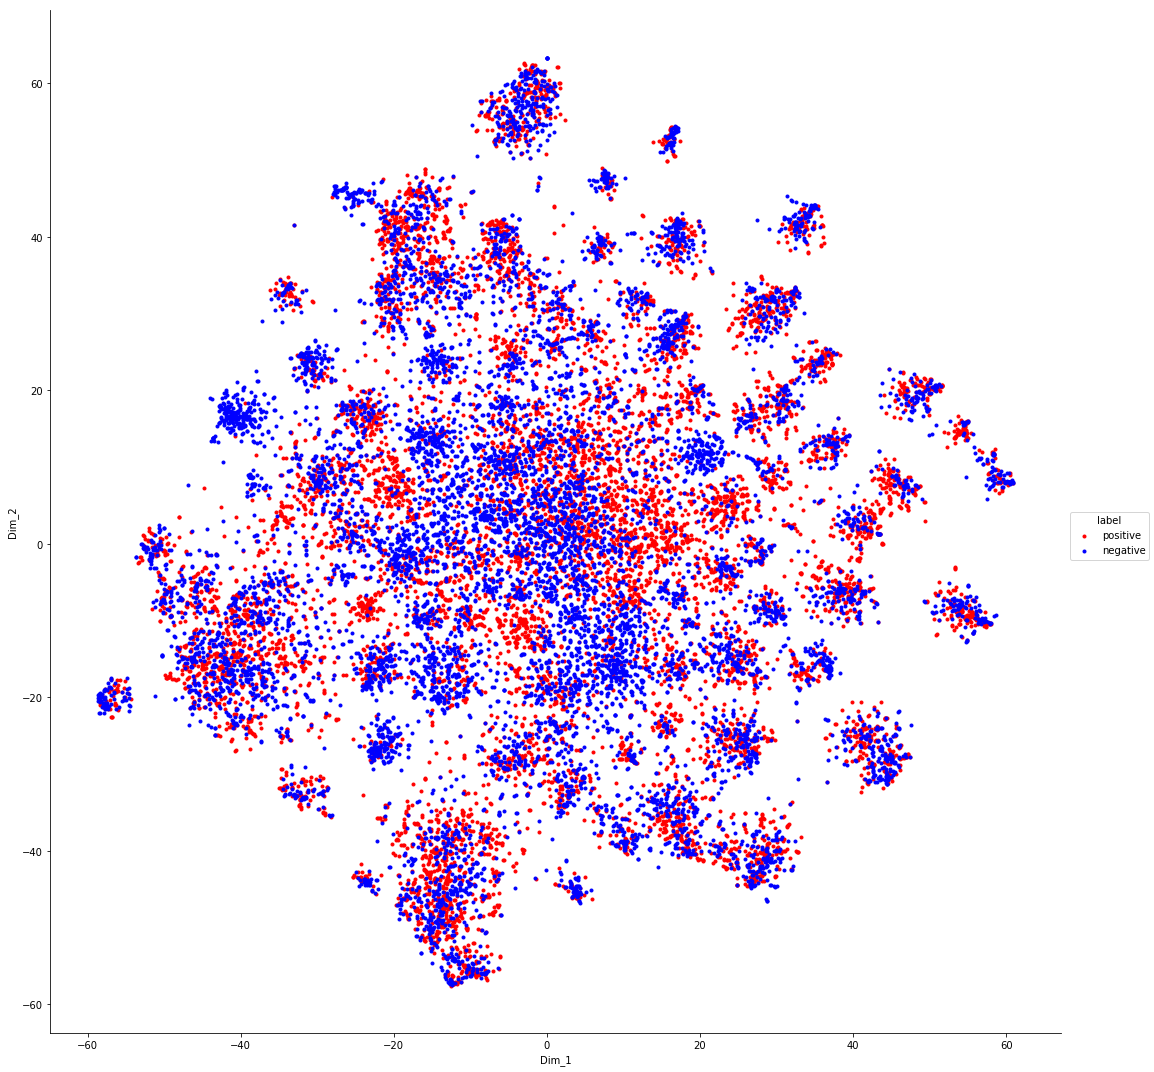

In [65]:
#Plotting TSNE using seaborn
tsne_df_tf_idf = pd.DataFrame(data=tsne_data_tf_idf1, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df_tf_idf, hue="label",hue_kws=dict(marker=[".", "."]),\
              size=15, palette=dict(positive="red", negative="blue"))\
              .map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

<b>Observation:-</b> Both the positive and negative reviews almost overlap for TSNE of TFIDF(bigrams) more or less the same as we saw for TSNE of BOW(unigrams) and TSNE of BOW(bigrams) which is undesirable.

# [7.2.6] Word2Vec

In [43]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell


#model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
#print("the vector representation of word 'computer'",model.wv['computer'])
#print("the similarity between the words 'woman' and 'man'",model.wv.similarity('woman', 'man'))
#print("the most similar words to the word 'woman'",model.wv.most_similar('woman'))
# this will raise an error
# model.wv.most_similar('tasti')  # "tasti" is the stemmed word for tasty, tastful

In [44]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in final20k['CleanedText'].values:
    list_of_sent.append(sent.split())

In [45]:
print(final20k['CleanedText'].values[1:4])
print("*****************************************************************")
print(list_of_sent[1:4]) #This is a list of lists.


['one drink coffe morn wast make pot one person bag terrif realli tast great use year continu use'
 'dont scare label extra bold realli not brew size set make call normal size cup coffe brew smooth easi drink cup look product hand guest fit bill comparison typic drink wake call brew tallest travel mug size set realli extra bold enjoy'
 'husband absolut addict tea year tri mani flavor varieti drink noth els']
*****************************************************************
[['one', 'drink', 'coffe', 'morn', 'wast', 'make', 'pot', 'one', 'person', 'bag', 'terrif', 'realli', 'tast', 'great', 'use', 'year', 'continu', 'use'], ['dont', 'scare', 'label', 'extra', 'bold', 'realli', 'not', 'brew', 'size', 'set', 'make', 'call', 'normal', 'size', 'cup', 'coffe', 'brew', 'smooth', 'easi', 'drink', 'cup', 'look', 'product', 'hand', 'guest', 'fit', 'bill', 'comparison', 'typic', 'drink', 'wake', 'call', 'brew', 'tallest', 'travel', 'mug', 'size', 'set', 'realli', 'extra', 'bold', 'enjoy'], ['husb

In [46]:
# min_count = 5 considers only words that occured atleast 5 times
time_start = time.time()

w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

print ('Word2Vec done! Time elapsed: {} seconds'.format(time.time()-time_start))

Word2Vec done! Time elapsed: 2.6483964920043945 seconds


In [47]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[50:100])

number of words that occured minimum 5 times  6463
sample words  ['look', 'product', 'hand', 'guest', 'fit', 'bill', 'comparison', 'typic', 'wake', 'travel', 'mug', 'enjoy', 'husband', 'absolut', 'addict', 'tea', 'tri', 'mani', 'flavor', 'varieti', 'noth', 'els', 'difficult', 'find', 'pumpkin', 'seed', 'area', 'turn', 'amazon', 'usual', 'eat', 'david', 'search', 'site', 'carri', 'came', 'across', 'review', 'seem', 'decent', 'enough', 'decid', 'give', 'disappoint', 'crispi', 'light', 'snack', 'take', 'shell', 'isnt']


In [48]:
w2v_model.wv.most_similar('tasti')

[('yummi', 0.9213184118270874),
 ('delici', 0.8516194224357605),
 ('crave', 0.824390172958374),
 ('crunch', 0.8237887620925903),
 ('satisfi', 0.812379777431488),
 ('crispi', 0.7999822497367859),
 ('graini', 0.7961512804031372),
 ('creami', 0.7741198539733887),
 ('dessert', 0.7735556364059448),
 ('crisp', 0.7696856260299683)]

In [49]:
w2v_model.wv.most_similar('burger')

[('marinad', 0.9762515425682068),
 ('hamburg', 0.9543763399124146),
 ('ham', 0.9515442848205566),
 ('grill', 0.9491604566574097),
 ('shrimp', 0.9430513381958008),
 ('casserol', 0.9428921937942505),
 ('stew', 0.9421154856681824),
 ('stroganoff', 0.9418717622756958),
 ('velveeta', 0.9362874627113342),
 ('steak', 0.935782253742218)]

In [50]:
count_vect_feat = count_vect.get_feature_names() # list of words in the BoW
print(count_vect_feat[count_vect_feat.index('like')])

like


# [7.2.7] Avg W2V, TFIDF-W2V

In [51]:
# average Word2Vec
# compute average word2vec for each review.
time_start = time.time()

sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]#vec = W2V of a word in a sent.
            sent_vec += vec #sum of all the W2V in a particular sent
            cnt_words += 1 #num of words in a sent
    if cnt_words != 0:
        sent_vec /= cnt_words #finally dividing sum of W2V by the num of words for a particular sentence.
    sent_vectors.append(sent_vec)#sentence vector is being populated.
#
print ('Avg Word2Vec done! Time elapsed: {} seconds'.format(time.time()-time_start))

Avg Word2Vec done! Time elapsed: 16.014127731323242 seconds


In [52]:
print(len(sent_vectors))
print(len(sent_vectors[0]))
print("the type of average Word2Vec ",type(sent_vectors))
print("the shape of our average Word2Vec ",np.shape(sent_vectors))

20000
50
the type of average Word2Vec  <class 'list'>
the shape of our average Word2Vec  (20000, 50)


In [53]:
#Since the Avg W2V is in form of a list, it should be converted to an Array to pass it to TSNE.
sent_vectors_array = np.array(sent_vectors)
print("the shape of our average Word2Vec ",np.shape(sent_vectors_array))
sent_vectors_array[0] # Lets have a look at a sentence vector created by (Avg W2V).

the shape of our average Word2Vec  (20000, 50)


array([-0.01996135,  0.35510127,  0.0777643 , -0.33803098,  0.15418919,
       -0.00287181,  0.9100855 , -0.02221388, -0.33288186,  0.1565005 ,
        0.21399895,  0.0811243 ,  0.36670556, -0.09378023,  0.13231326,
       -0.19947649,  0.0165761 , -0.08406511, -0.66251028,  0.6238147 ,
        0.65899516, -0.35761846, -0.47168263,  0.75823794,  0.29208223,
       -0.420022  ,  0.37088325,  0.27547786,  0.25469001, -0.34222817,
        0.91869071, -0.05955589,  0.63272406,  0.07356004,  0.1803981 ,
        0.30672247, -0.08179615, -0.00495191, -0.26948335,  0.70567431,
        0.40005558, -0.00998605,  0.01419384,  0.41994207, -0.14147907,
        0.78437989, -0.04870867,  0.45796695, -0.15088651,  0.58172517])

In [55]:
#Dimensionality reduction of average Word2Vec vectors TSNE.
time_start = time.time()

from MulticoreTSNE import MulticoreTSNE as TSNE
labels_20k = final20k['Score'].values

model = TSNE(n_components=2, random_state=0, perplexity=30,  n_iter=5000, n_jobs = 6)

tsne_data_sent_vectors = model.fit_transform(sent_vectors_array)

print ('MulticoreTSNE on average Word2Vec done! Time elapsed: {} seconds'.format(time.time()-time_start))
tsne_data_sent_vectors1 = np.vstack((tsne_data_sent_vectors.T, labels_20k)).T #Run this line only once.

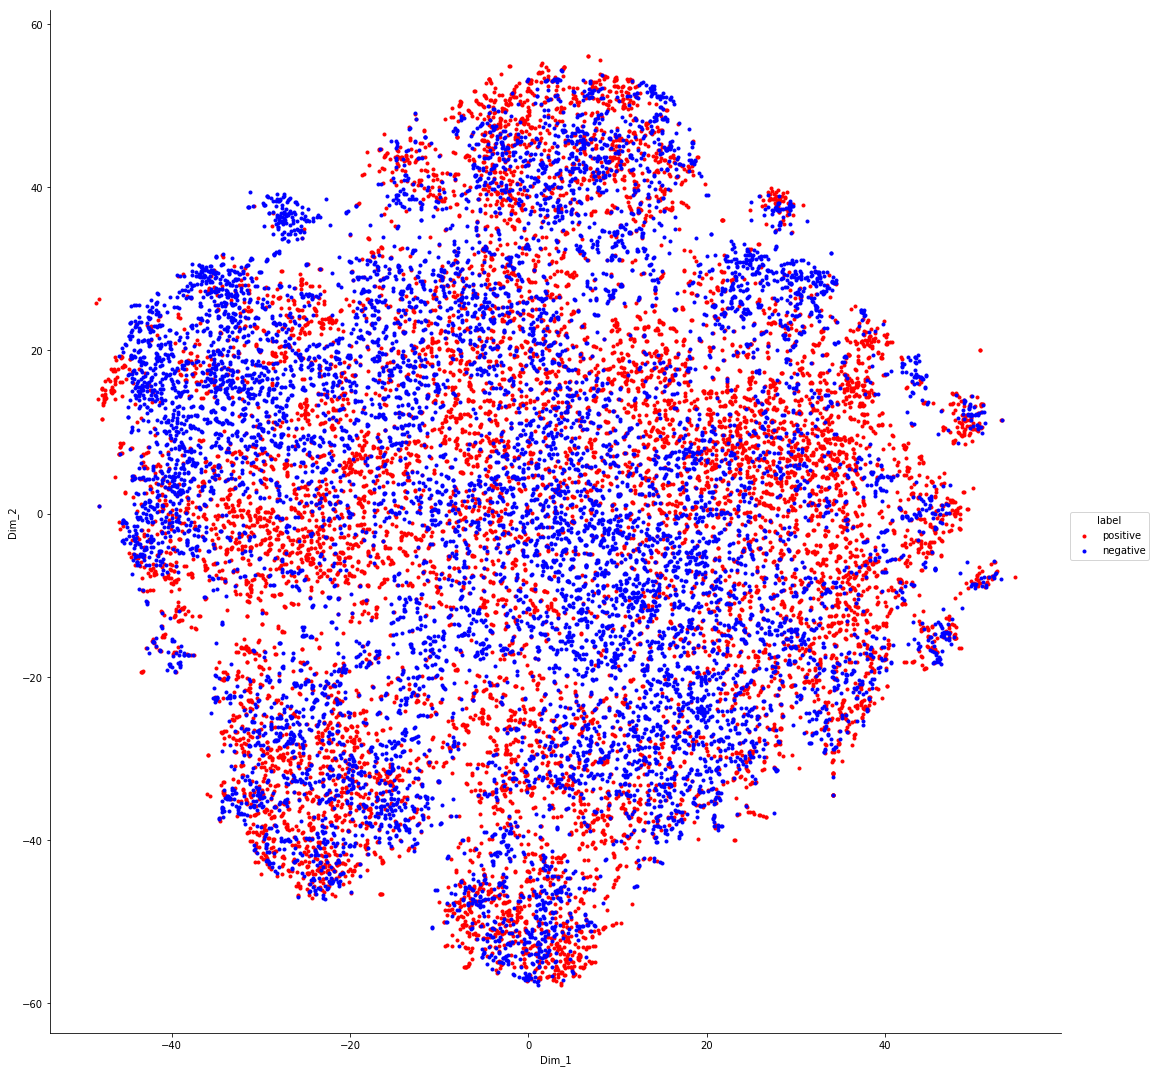

In [66]:
#Plotting TSNE using seaborn
tsne_df_sent_vectors = pd.DataFrame(data=tsne_data_sent_vectors1, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df_sent_vectors, hue="label",hue_kws=dict(marker=[".", "."]),\
              size=15, palette=dict(positive="red", negative="blue"))\
              .map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

<b>Observation:-</b> Both the positive and negative reviews almost overlap for TSNE of Sentence vectors of Avg W2V more or less the same as we saw for TSNE of BOW(unigrams) and TSNE of BOW(bigrams) which is undesirable.

In [58]:
# TF-IDF weighted Word2Vec
time_start = time.time()

tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word] #vec = W2V of a word in a sent.
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf) #sum of all the product of TF-IDF and W2V in a particular sentence
            weight_sum += tf_idf #sum of all the TF-IDF of all the words in sentence (sparse matrix)
    if weight_sum != 0:
        sent_vec /= weight_sum #finally calculating avg
    tfidf_sent_vectors.extend(sent_vec)# sentence vector is being populated.
    row += 1

print ('TF-IDF weighted Word2Vec done! Time elapsed: {} seconds'.format(time.time()-time_start))

TF-IDF weighted Word2Vec done! Time elapsed: 9825.90629529953 seconds


In [59]:
print(len(tfidf_sent_vectors))
print(len(tfidf_sent_vectors[0]))
print("the type of TF-IDF weighted Word2Vec ",type(tfidf_sent_vectors))
print("the shape of our TF-IDF weighted Word2Vec ",np.shape(tfidf_sent_vectors))

20000
50
the type of TF-IDF weighted Word2Vec  <class 'list'>
the shape of our TF-IDF weighted Word2Vec  (20000, 50)


In [60]:
#Since the TF-IDF weighted Word2Vec is in form of a list, it should be converted to an Array to pass it to TSNE.
tfidf_sent_vectors_array = np.array(tfidf_sent_vectors)
print("the shape of our average Word2Vec ",np.shape(tfidf_sent_vectors_array))
tfidf_sent_vectors_array[0] # Let's have a look at a sentence vector created by (TF-IDF weighted W2V).

the shape of our average Word2Vec  (20000, 50)


array([-0.13260217,  0.3919776 ,  0.0624393 , -0.32936483,  0.1613144 ,
        0.02563387,  0.92490935, -0.06425854, -0.36215028,  0.20642432,
        0.17663607,  0.18193755,  0.48991196, -0.21666631,  0.31941695,
       -0.16948587,  0.05060022, -0.11425412, -0.57437057,  0.54454107,
        0.67431711, -0.43200693, -0.44756431,  0.74918049,  0.31428022,
       -0.29106312,  0.24076688,  0.37636012,  0.40634458, -0.20039246,
        0.82724784,  0.06144203,  0.50828847, -0.00268827,  0.39198376,
        0.25838692, -0.16395324,  0.14167082, -0.26644446,  0.67149972,
        0.41178317,  0.106893  ,  0.03302898,  0.3870869 , -0.14395232,
        0.83770326, -0.10651219,  0.41900009, -0.3129693 ,  0.44590642])

In [61]:
#Dimensionality reduction of TF-IDF weighted Word2Vec vectors TSNE.

#%load_ext wurlitzer #To make the computation log visible 

time_start = time.time()

from MulticoreTSNE import MulticoreTSNE as TSNE
labels_20k = final20k['Score'].values

model = TSNE(n_components=2, random_state=0, perplexity=30,  n_iter=5000, n_jobs = 6)

TSNE_data_tfidf_sent_vectors = model.fit_transform(tfidf_sent_vectors_array)

print ('MulticoreTSNE on TF-IDF weighted Word2Vec done! Time elapsed: {} seconds'.format(time.time()-time_start))
tsne_data_tfidf_sent_vectors1 = np.vstack((TSNE_data_tfidf_sent_vectors.T, labels_20k)).T #Run this line only once.

MulticoreTSNE on TF-IDF weighted Word2Vec done! Time elapsed: 220.75071573257446 seconds


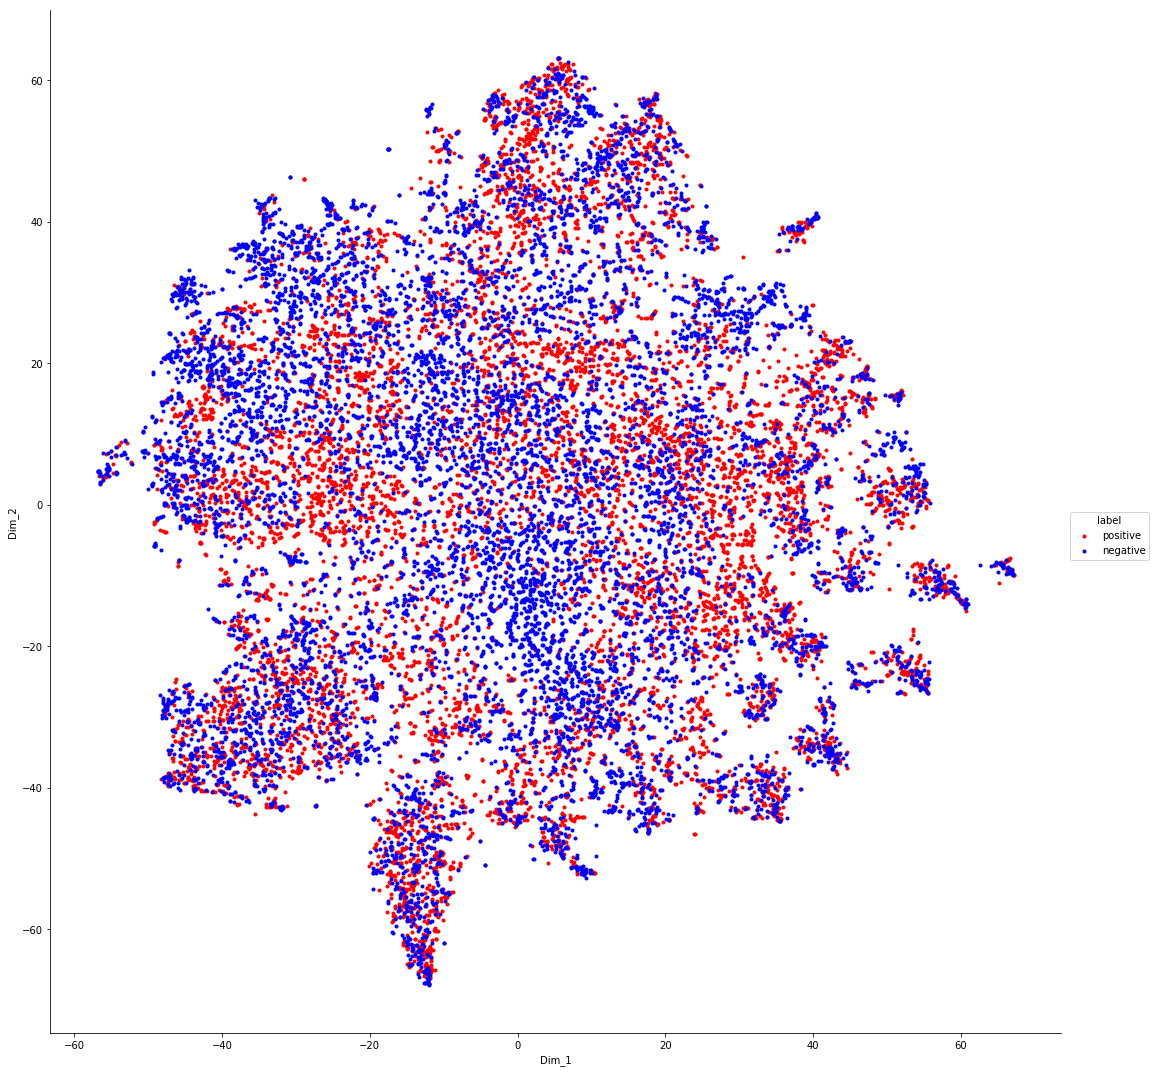

In [67]:
#Plotting TSNE using seaborn
tsne_df_tfidf_sent_vectors = pd.DataFrame(data=tsne_data_tfidf_sent_vectors1, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df_tfidf_sent_vectors, hue="label",hue_kws=dict(marker=[".", "."]),\
              size=15, palette=dict(positive="red", negative="blue"))\
              .map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

<b>Observation:-</b> Both the positive and negative reviews almost overlap for TSNE of Sentence vectors of TF-IDF weighted Word2Vec more or less the same as we saw for TSNE of BOW(unigrams) and TSNE of BOW(bigrams) which is undesirable.